In [ ]:
%matplotlib inline

# Neural Transfer Using PyTorch
### Architecture Used - CNN Model
### Model Used - VGG19
### Loss Used - Two losses: Style Loss and Content Loss (both mse) to minimize the distance of the target image with both the images.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [1]:
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
!git clone https://github.com/Kratos-is-here/Style-Transfer-Dashtoon-Assignment.git
!mv /content/Style-Transfer-Dashtoon-Assignment/Images/* ./

--2023-11-24 19:02:47--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.002s  

2023-11-24 19:02:47 (63.9 MB/s) - ‘picasso.jpg’ saved [114573/114573]

--2023-11-24 19:02:47--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K  --.-KB/s    in 0.002s  

2023-11-24 19:02:48 (23.4 MB/s)

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("gow1.jpg")
content_img = image_loader("bhu4.jpg")

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

torch.Size([1, 3, 512, 910])
torch.Size([1, 3, 512, 910])


Now, let's create a function that displays an image by reconverting a
copy of it to PIL format and displaying the copy using
``plt.imshow``. We will try displaying the content and style images
to ensure they were imported correctly.



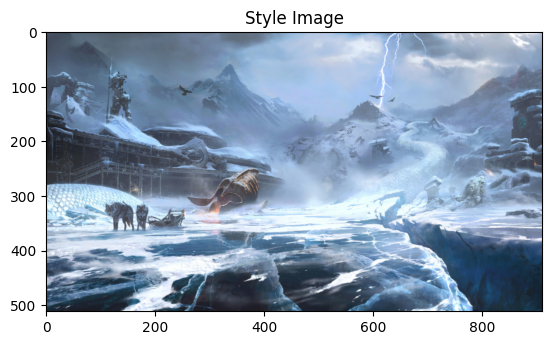

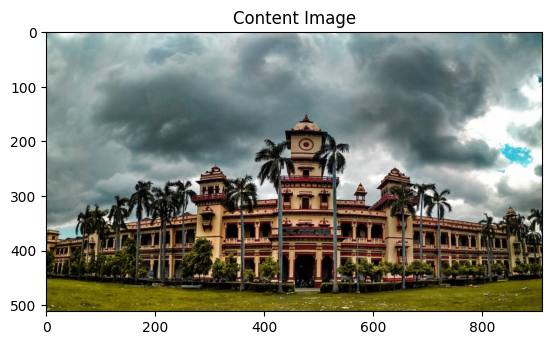

In [ ]:
unloader = transforms.ToPILImage()
plt.ion()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()

    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

Now the style loss module looks almost exactly like the content loss
module. The style distance is also computed using the mean square
error between $G_{XL}$ and $G_{SL}$.




In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Importing the Model

Now we need to import a pretrained neural network. We will use a 19
layer VGG network like the one used in the paper.



In [ ]:
cnn = vgg19(VGG19_Weights.DEFAULT).features.eval()

In [ ]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
Thus we use them to normalize the images




In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (``Conv2d``, ``ReLU``, ``MaxPool2d``,
``Conv2d``, ``ReLU``…) aligned in the right order of depth. We need to add our
content loss and style loss layers immediately after the convolution
layer they are detecting. To do this we must create a new ``Sequential``
module that has content loss and style loss modules correctly inserted.




In [ ]:
import torchvision

In [ ]:
# desired depth layers to compute style/content losses
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        elif isinstance(layer, torchvision.ops.Conv2dNormActivation):
            name = 'an_{}'.format(i)
        elif isinstance(layer, nn.Sequential):
            name = 'sq_{}'.format(i)
        else:
            raise RuntimeError('Please check for this layer in your model: {}'.format(layer.__class__.__name__))
        model.add_module(name, layer)
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

## Gradient Descent
We will create a PyTorch L-BFGS optimizer ``optim.LBFGS`` and pass
our image to it as the tensor to optimize.




In [ ]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)
    optimizer = get_input_optimizer(input_img)
    run = [0]
    while run[0] <= num_steps:
        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
                print()
            return style_score + content_score
        optimizer.step(closure)
    with torch.no_grad():
        input_img.clamp_(0, 1)
    return input_img

Finally, we can run the algorithm.




In [ ]:
style_img = image_loader("gow4.jpg")
content_img = image_loader("bhu4.jpg")
assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

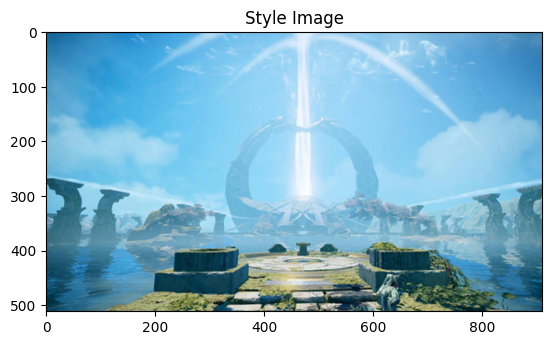

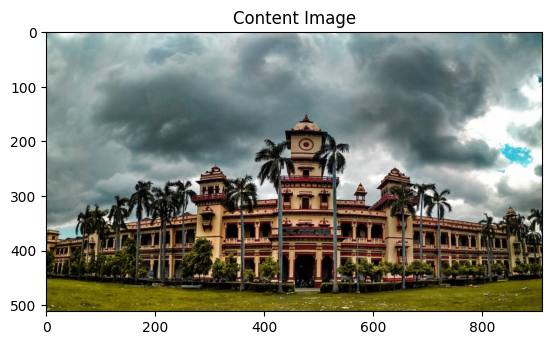

In [ ]:
unloader = transforms.ToPILImage()
plt.ion()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


run [50]:
Style Loss : 107.213135 Content Loss: 15.704548

run [100]:
Style Loss : 24.271057 Content Loss: 15.795756

run [150]:
Style Loss : 8.332295 Content Loss: 13.849362

run [200]:
Style Loss : 4.350057 Content Loss: 11.577799

run [250]:
Style Loss : 3.097225 Content Loss: 10.189260

run [300]:
Style Loss : 1.930781 Content Loss: 9.620740



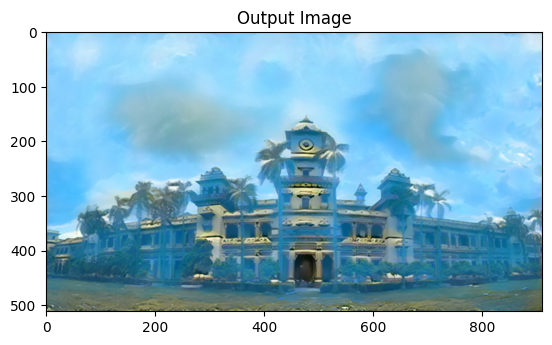

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, content_img)

plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()